In [1]:
import pandas as pd
from gamescout_db import db, cur
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import numpy as np
import math
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

import statsmodels.discrete.discrete_model as sm

In [ ]:
# DATA COLLECTION

In [ ]:
batter_stats_COLUMNS = ['HITS','1_AGO_AVG', '2_AGO_AVG', '3_AGO_AVG', '4_AGO_AVG', '5_AGO_AVG', '6_AGO_AVG','7_AGO_AVG', 'P_ID','G_ID', 'BAT_ORDER', 'G_DATE', 'TEAM']

at_bats_COLUMNS = ['BATTER', 'PITCHER', 'G_ID', 'BATTER_LR', 'PITCHER_LR', 'TIME', 'EVENT']

pitcher_stats_COLUMNS = ['P_ID', 'G_ID', 'GAME_SCORE', 'BATTERS_FACED', 'TEAM', 'GAME_SCORE_1AGO', 'GAME_SCORE_2AGO', 'GAME_SCORE_3AGO']

In [ ]:
batter_stats = pd.read_sql('select * from BatterStats;', con=db)[batter_stats_COLUMNS]
batter_stats["GOT_HIT"] = [1 if x > 0 else 0 for x in batter_stats["HITS"]]
batter_stats["NOT_HIT"] = [1 if x == 0 else 0 for x in batter_stats["HITS"]]

batter_stats["1_AGO"] = [0 if x == 0 else 1 for x in batter_stats["1_AGO_AVG"]]
batter_stats["2_AGO"] = [0 if x == 0 else 1 for x in batter_stats["2_AGO_AVG"]]
batter_stats["3_AGO"] = [0 if x == 0 else 1 for x in batter_stats["3_AGO_AVG"]]
batter_stats["4_AGO"] = [0 if x == 0 else 1 for x in batter_stats["4_AGO_AVG"]]
batter_stats["5_AGO"] = [0 if x == 0 else 1 for x in batter_stats["5_AGO_AVG"]]
batter_stats["6_AGO"] = [0 if x == 0 else 1 for x in batter_stats["6_AGO_AVG"]]
batter_stats["7_AGO"] = [0 if x == 0 else 1 for x in batter_stats["7_AGO_AVG"]]

batter_stats = batter_stats[['GOT_HIT', 'NOT_HIT', '1_AGO', '2_AGO', '3_AGO', '4_AGO', '5_AGO', '6_AGO','7_AGO', 'P_ID', 'G_ID', 'BAT_ORDER', 'G_DATE', 'TEAM']]

In [ ]:
pitcher_stats = pd.read_sql('select * from PitcherStats;', con=db)[pitcher_stats_COLUMNS]

In [ ]:
at_bats = pd.read_sql('select * from AtBats;', con=db)[at_bats_COLUMNS]

In [ ]:
hist_AB_series = []
hist_H_series = []
OPP_ID_series = []
GS1AGO_series = []
GS2AGO_series = []
GS3AGO_series = []
order_series = []

for i in range(0, len(batter_stats)):
    batter = batter_stats.ix[i]
    starting_pitcher = pitcher_stats[pitcher_stats['G_ID'] == batter['G_ID']]
    starting_pitcher = starting_pitcher[pitcher_stats['TEAM'] != batter['TEAM']]
    starting_pitcher = starting_pitcher.sort(['BATTERS_FACED'], ascending=False).head(1)

    matchups = at_bats[at_bats['BATTER'] == batter['P_ID']]
    matchups = matchups[at_bats['PITCHER'] == starting_pitcher['P_ID'].iloc[0]]
    matchups = matchups[at_bats['TIME'] < batter['G_DATE']]
    matchups_hits = matchups[matchups['EVENT'].isin(['Single', 'Double', 'Triple', 'Home Run'])]

    hist_AB = len(matchups)
    hist_H = len(matchups_hits)

    hist_AB_series.append(hist_AB)
    hist_H_series.append(hist_H)
    OPP_ID_series.append(starting_pitcher['P_ID'].iloc[0])
    
    GS1AGO_series.append(starting_pitcher['GAME_SCORE_1AGO'].iloc[0])
    GS2AGO_series.append(starting_pitcher['GAME_SCORE_2AGO'].iloc[0])
    GS3AGO_series.append(starting_pitcher['GAME_SCORE_3AGO'].iloc[0])
    
    order_series.append(batter['BAT_ORDER'])
    
    if i % 5000 == 0:
        print i
    
batter_stats['hist_AB'] = pd.Series(hist_AB_series)
batter_stats['hist_H'] = pd.Series(hist_H_series)
batter_stats['starting_P_ID'] = pd.Series(OPP_ID_series)
batter_stats['GS1AGO'] = pd.Series(GS1AGO_series)
batter_stats['GS2AGO'] = pd.Series(GS2AGO_series)
batter_stats['GS3AGO'] = pd.Series(GS3AGO_series)
batter_stats['BAT_ORDER'] = pd.Series(order_series)

In [ ]:
# batter_stats.to_csv('SAVED.csv')

In [2]:
compiled = pd.read_sql('select * from Compiled;', con=db)

In [3]:
data = compiled.copy()
data = data[pd.notnull(data['GS1AGO'])]
data = data[pd.notnull(data['GS2AGO'])]
data = data[pd.notnull(data['GS3AGO'])]

labels = data['GOT_HIT']
data = data[['1_AGO', '2_AGO', '3_AGO', '4_AGO', '5_AGO', '6_AGO', '7_AGO', 'GS1AGO', 'GS2AGO', 'GS3AGO', 
             'starting_P_ID', 'P_ID', 'hist_AB', 'hist_H']]

# data = pd.concat([data, pd.get_dummies(data['starting_P_ID']).iloc[:,1:697]], axis=1)
# data = pd.concat([data, pd.get_dummies(data['P_ID']).iloc[:,1:3264]], axis=1)

(array([  7.75900000e+03,   3.02263000e+05,   2.00320000e+04,
          4.35200000e+03,   9.50000000e+02,   2.29000000e+02,
          6.30000000e+01,   3.10000000e+01,   1.70000000e+01,
          3.00000000e+00]),
 array([ -2.7 ,  -0.48,   1.74,   3.96,   6.18,   8.4 ,  10.62,  12.84,
         15.06,  17.28,  19.5 ]),
 <a list of 10 Patch objects>)

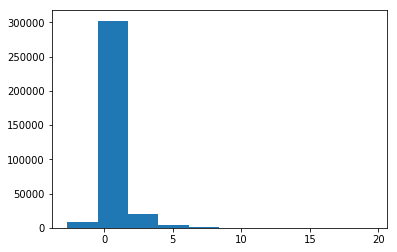

In [4]:
# H^1.2 - (.1 * AB^1.2)

data['Gamma'] = data['hist_H'] - (.1 * data['hist_AB'])
#plt.scatter(data['hist_H'], data['hist_AB'], s=.1)
plt.hist(data['Gamma'])

In [5]:
data_done = data[[col for col in data.columns if col not in ['starting_P_ID', 'P_ID', 'hist_AB', 'hist_H']]]

In [6]:
y = labels
x = data_done

In [7]:
# LINEAR REGRESSION MODEL



In [8]:
train_x = x[:250000]
test_x = x[250001:]

train_y = y[:250000]
test_y = y[250001:]

In [14]:
model = linear_model.LogisticRegression(class_weight='balanced')
model.fit(train_x, train_y)

for index, col in enumerate(x.columns):
    print("{0}: {1}".format(col, model.coef_[0][index]))

1_AGO: -0.242238247618
2_AGO: -0.266216572103
3_AGO: -0.276066173254
4_AGO: -0.296714878469
5_AGO: -0.298259439682
6_AGO: -0.285676111771
7_AGO: -0.294812507414
GS1AGO: -0.000762875150873
GS2AGO: -0.000837129579346
GS3AGO: -0.00154972829708
Gamma: 0.346347831037


In [9]:
logit = sm.Logit(y, x)

In [10]:
f = logit.fit()

Optimization terminated successfully.
         Current function value: 0.644807
         Iterations 5


In [16]:
f.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                GOT_HIT   No. Observations:               335699
Model:                          Logit   Df Residuals:                   335688
Method:                           MLE   Df Model:                           10
Date:                Sun, 14 May 2017   Pseudo R-squ.:                 0.04722
Time:                        12:26:25   Log-Likelihood:            -2.1646e+05
converged:                       True   LL-Null:                   -2.2719e+05
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1_AGO         -0.1501      0.008    -18.825      0.000      -0.166      -0.134
2_AGO         -0.1802      0.008    -22.520      0.000      -0.196      -0.164
3_AGO         -0.1989      0.008    -24.810      0.000      -0.215      -0.183
4_AGO         -0.2036      0.008    -25.367      0.000      -0.219      -0.188
5_AGO         -0.2107      0.008    -26.236      0.000      -0.226      -0.195
6_AGO         -0.1966      0.008    -24.478      0.000      -0.212      -0.181
7_AGO         -0.2064      0.008    -25.726      0.000      -0.222      -0.191
GS1AGO         0.0030      0.000     18.404      0.000       0.003       0.003
GS2AGO         0.0028      0.000     17.296      0.000       0.003       0.003
GS3AGO         0.0023      0.000     14.331      0.000       0.002       0.003
Gamma          0.3331      0.004     84.370      0.000       0.325       0.341
==============================================================================
"""

In [ ]:
plt.hist(model.predict_proba(test_x)[:,0])

In [ ]:
predicted = model.predict(test_x)
expected = test_y

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

In [ ]:
model.score(test_x, test_y)

In [ ]:
# DO OUR FEATURES CORRELATE TO PERFORMANCE?

In [ ]:
probs = model.predict_proba(test_x)[:,1]
pairs = zip(expected, probs)

In [ ]:
prob_bins = {}
x = np.array([probs])
bins = np.linspace(0, 1, num=101)

inds = np.digitize(x, bins)

for i, pair in enumerate(pairs):
    key = str(inds[0][i] - 1)
    
    if key not in prob_bins:
        #print(key)
        prob_bins[key] = []
        
    prob_bins[key].append(pair)

In [ ]:
pct_hit = []
for key in sorted(prob_bins.keys()):
    hits = [sum(x) for x in zip(*prob_bins[str(key)])][0]
    total = len(prob_bins[str(key)])
    pct = float(hits)/float(total)
    pct_hit.append(pct)

#     print("Bin: " + str(key))
#     print("# players w/ hit: " + str(hits))
#     print("# player (total): " + str(total))
#     print("Pct. Hit: " + str(float(hits)/float(total)))
#     print("")

In [ ]:
plt.scatter(sorted([float(i)/100 for i in prob_bins.keys()]),pct_hit)
plt.plot([0.35, 0.65], [0.35, 0.65], "-")